# Load lib

In [3]:
from si_prefix import si_format
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
apitoken='5796668ee5b1b6c42dba99e7aa77bfdc8c980d7ce767895fa79b2971797ab08a6ab6e8b4db870153cb724887818d1cee5090c909f7d2fb610d9b128e0bd41b63'
try:
    IBMQ.enable_account(token=apitoken)
except:
    pass

IBMQ.providers()

C:\Users\racco\AppData\Roaming\Python\Python37\site-packages\qiskit\providers\ibmq\ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

In [22]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  This is separate from the ipykernel package so we can avoid doing imports until


# Load system values

In [5]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [6]:
dt = backend_config.dt
print("Sampling time: {}s".format(si_format(dt)))    
backend_defaults = backend.defaults()

Sampling time: 222.2 ps


In [8]:
qubit = 0

In [24]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [21]:
# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

Qubit 0 has an estimated frequency of 4.974443934441322 GHz.


# Define sweep

In [19]:
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_span_Hz =   40e6
frequency_step_Hz = 0.55e6
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print("The sweep will go from {}Hz to {}Hz in steps of {}Hz.".format(si_format(frequency_min,3),
                                                                     si_format(frequency_max,3),
                                                                     si_format(frequency_step_Hz)))

The sweep will go from 4.954 GHz to 4.994 GHz in steps of 550.0 kHz.


In [28]:
# Drive pulse parameters
drive_sigma_us = 0.075*1e-6             # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8     # This is a truncating parameter, because gaussians don't have a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us /dt)   # The truncating parameter in units of dt
drive_amp = 0.15
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(sigma=drive_sigma,
                                 duration=drive_samples,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [29]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [31]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [32]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*1e9
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

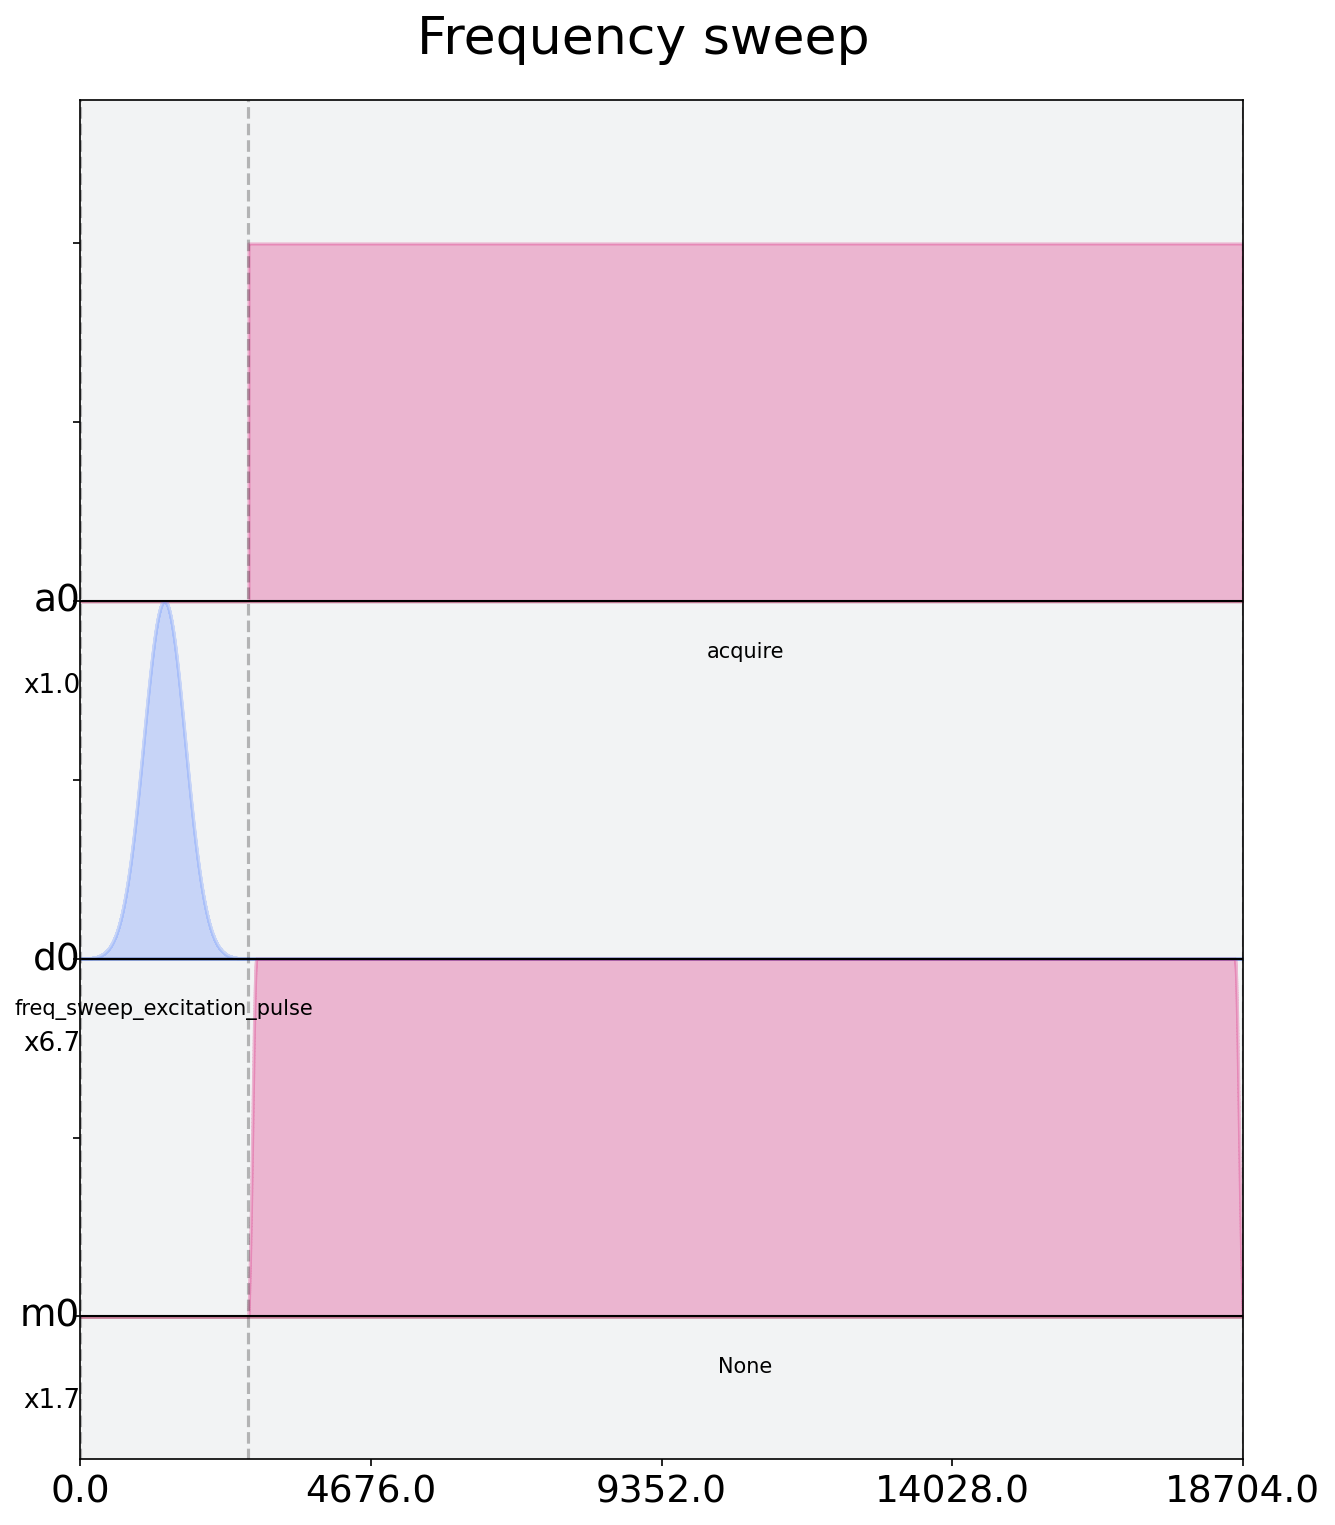

In [33]:
schedule.draw(label=True)

In [34]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [35]:
job = backend.run(frequency_sweep_program)

In [36]:
# print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [37]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

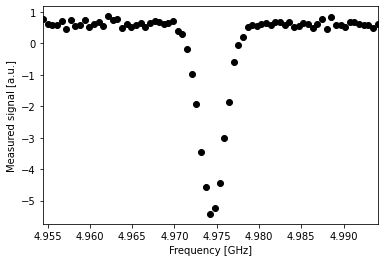

In [38]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

# Our practice

To better understand the peak level difference at different simplitude we would likt to plot everything together

<IPython.core.display.Javascript object>


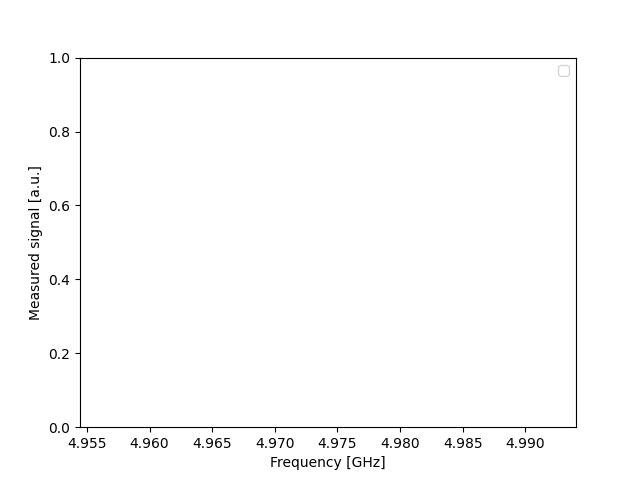

No handles with labels found to put in legend.


In [22]:
%matplotlib notebook

f,ax = plt.subplots()
ax.set_xlim([min(frequencies_GHz), max(frequencies_GHz)])
ax.set_xlabel("Frequency [GHz]")
ax.set_ylabel("Measured signal [a.u.]")
ax.legend()

In [32]:
amp_list = np.arange(0.1,0.15,0.05)
for amp in amp_list:
    # The sweep will be centered around the estimated qubit frequency.
    center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                        # warning: this will change in a future release
    print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

    # scale factor to remove factors of 10 from the data
    scale_factor = 1e-14

    # We will sweep 30 MHz around the estimated frequency
    frequency_span_Hz = 20 * MHz
    # in steps of 400 kHz.
    frequency_step_Hz = 0.40 * MHz

    # We will sweep 20 MHz above and 20 MHz below the estimated frequency
    frequency_min = center_frequency_Hz - frequency_span_Hz / 2
    frequency_max = center_frequency_Hz + frequency_span_Hz / 2
    # Construct an np array of the frequencies for our experiment
    frequencies_GHz = np.arange(frequency_min / GHz, 
                                frequency_max / GHz, 
                                frequency_step_Hz / GHz)

    print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
    in steps of {frequency_step_Hz / MHz} MHz.")

    # Drive pulse parameters (us = microseconds)
    drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
    drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                               # a natural finite length

    drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
    drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
    drive_amp = amp
    # Drive pulse samples
    drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                     sigma=drive_sigma,
                                     amp=drive_amp,
                                     name='freq_sweep_excitation_pulse')

    job = backend.run(frequency_sweep_program)
    job_monitor(job)
    frequency_sweep_results = job.result(timeout=60*60) # timeout parameter set to 120 seconds

    sweep_values = []
    for i in range(len(frequency_sweep_results.results)):
        # Get the results from the ith experiment
        res = frequency_sweep_results.get_memory(i)*scale_factor
        # Get the results for `qubit` from this experiment
        sweep_values.append(res[qubit])

    ax.plot(frequencies_GHz, np.real(sweep_values), marker = 'dot', label = 'amp={:.3}'.format(drive_amp))

Qubit 0 has an estimated frequency of 4.974444097612365 GHz.
The sweep will go from 4.964444097612366 GHz to 4.984444097612366 GHz     in steps of 0.4 MHz.
Job Status: job has successfully run


ValueError: x and y must have same first dimension, but have shapes (51,) and (73,)

to do: check python file I/O to record data

The end of the test

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [17]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-5, 4.975, 1, 3] # initial parameters for curve_fit
                                )

NameError: name 'sweep_values' is not defined

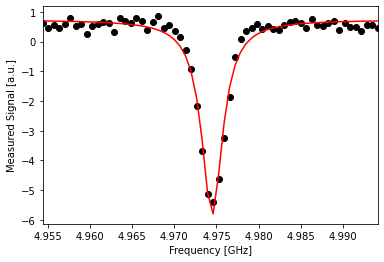

In [24]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [25]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97445 GHz to 4.97449 GHz.


In [42]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.35
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [43]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

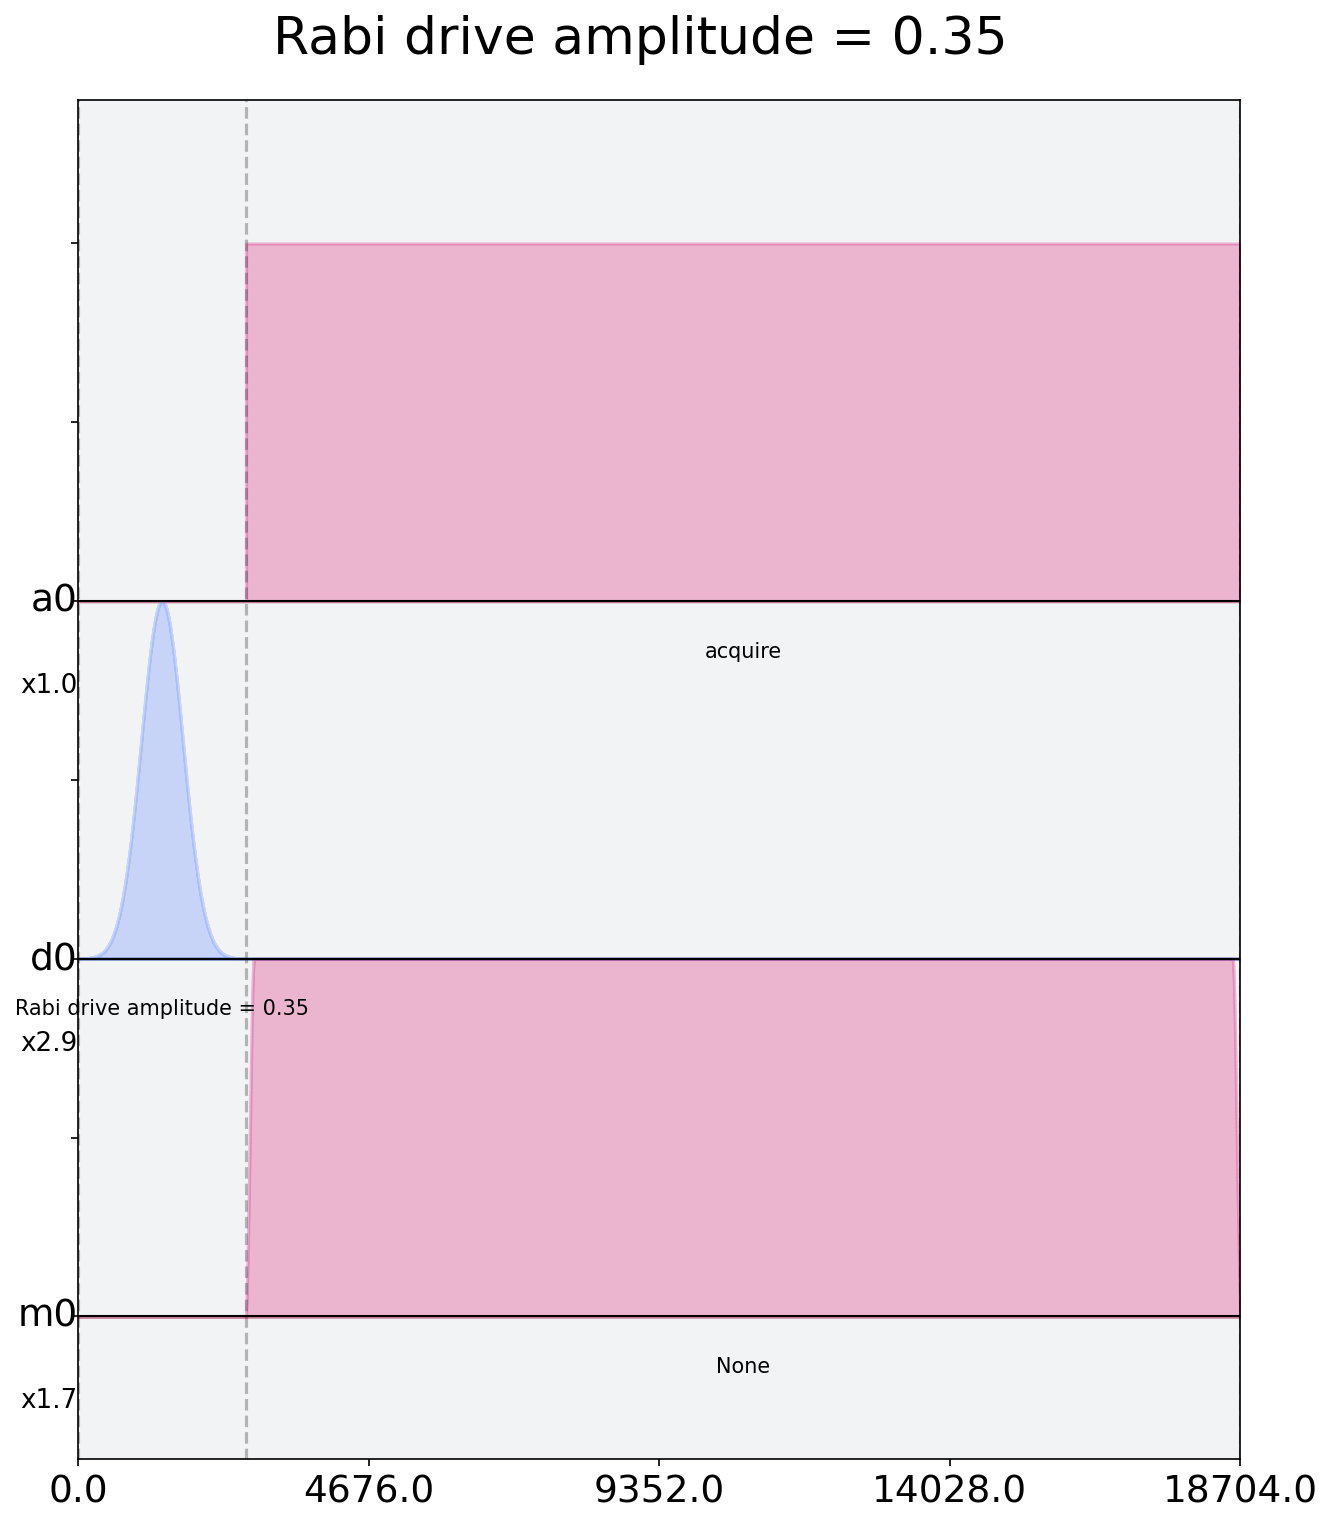

In [44]:
rabi_schedules[-1].draw(label=True)

In [45]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [46]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

5fdf2142540cbd00192cb71f
Job Status: job has successfully run


In [47]:
rabi_results = job.result(timeout=120)

In [48]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

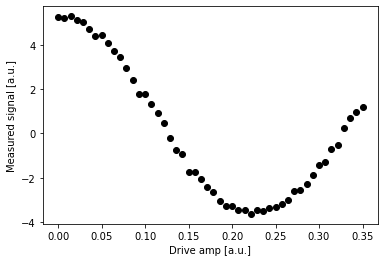

In [49]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()